# Lab 6 (Part B) : Spam Classification using SVM

In this part of the Lab (Part B), you will be using support vector machines to build a spam classifier. Make sure that you check the videos of lecture 6 before starting this Lab:
- Support Vector Machines (SVM): https://youtu.be/ZAqj96d3cOw

Many email services today provide spam filters that are able to classify emails into spam and non-spam email with high accuracy. In this part of the Lab, you will use SVM to build your own spam filter.

You will be training a classifier to classify whether a given email $x$ is spam $(y = 1)$ or non-spam $(y = 0)$. In particular, you need to convert each email into a feature-vector $x \in \mathbb{R}^d$. The following parts of the exercise will walk you through how such a feature-vector can be constructed from an email.

The dataset included for this Lab is based on a subset of the [SpamAssassin public dataset](http://spamassassin.apache.org/old/publiccorpus/). For the purpose of this Lab, you will only be using the body of the email (excluding the email headers).

## 1. Preprocessing Emails
Before starting on a machine learning task, it is usually insightful to take a look at examples from the dataset. The following example shows a sample email that contains a URL, an email address (at the end), numbers, and dollar amounts.

> \> Anyone knows how much it costs to host a web portal ? <br />
> \> <br />
> Well, it depends on how many visitors youre expecting. This can be <br />
> anywhere from less than 10 bucks a month to a couple of $100. You <br />
> should checkout http://www.rackspace.com/ or perhaps Amazon EC2 if <br />
> youre running something big.. <br />
> To unsubscribe yourself from this mailing list, send an email to: <br />
> groupname-unsubscribe@egroups.com <br />

While many emails would contain similar types of entities (e.g., numbers, other URLs, or other email addresses), the specific entities (e.g., the specific URL or specific dollar amount) will be different in almost every email. Therefore, one method often employed in processing emails is to *"normalize"* these values, so that all URLs are treated the same, all numbers are treated the same, etc. For example, we could replace each URL in the email with the unique string *"httpaddr"* to indicate that a URL was present. This has the effect of letting the spam classifier make a classification decision based on whether any URL was present, rather than whether a specific URL was present. This typically improves the performance of a spam classifier, since spammers often randomize the URLs, and thus the odds of seeing any particular URL again in a new piece of spam is very small.

In `processEmail(..)`, we have implemented the following email preprocessing and normalization steps:

- Lower-casing: The entire email is converted into lower case, so that captialization is ignored (e.g., IndIcaTE is treated the same as Indicate).

- Stripping HTML: All HTML tags are removed from the emails. Many emails often come with HTML formatting; we remove all the HTML tags, so that only the content remains.

- Normalizing URLs: All URLs are replaced with the text "httpaddr".

- Normalizing Email Addresses: All email addresses are replaced with the text "emailaddr".

- Normalizing Numbers: All numbers are replaced with the text "number".

- Normalizing Dollars: All dollar signs (\$) are replaced with the text "dollar".

- Removal of non-words: Non-words and punctuation have been removed. All white spaces (tabs, newlines, spaces) have all been trimmed to a single space character.

- Word Stemming: Words are reduced to their stemmed form. For example, "discount", "discounts", "discounted" and "discounting" are all replaced with "discount". Sometimes, the Stemmer actually strips off additional characters from the end, so "include", "includes", "included", and "including" are all replaced with "includ".

The result of these preprocessing steps on the previous sample email, is shown as follows. While preprocessing has left word fragments and non-words, this form turns out to be much easier to work with for performing feature extraction.

> anyon know how much it cost to host web portal well it depend on how mani visitor your expect this can be anywher from less than number buck month to coupl of dollarnumb you should checkout httpaddr or perhap amazon ecnumb if your run someth big to unsubscrib yourself from this mail list send an email to emailaddr

**Note:** To run the following code, you need to install the imported libraries (e.g. `stemming`) if not installed. To do so, you can use `pip install stemming` command.

In [1]:
import re, string
from stemming.porter2 import stem

def processEmail(text):
    text = text.lower()                                         # Lower case
    text = re.sub("<[^<>]+>", " ", text)                        # Strip all HTML
    text = re.sub("[0-9]+", "number", text)                     # Handle numbers
    text = re.sub("(http|https)://[^\s]*", "httpaddr", text)    # Handle URLS
    text = re.sub("[^\s]+@[^\s]+", "emailaddr", text)           # Handle email addresses
    text = re.sub("[$]+", "dollar", text)                       # Handle $ sign
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove any punctuation
    text = re.sub("\s+", " ", text).strip()                     # Replace multiple white spaces with one space
    text = re.sub("[^a-zA-Z0-9 ]", "", text)                    # Remove any other non-alphanumeric characters
    text = " ".join([ stem(word) for word in text.split(" ") ]) # Stemming all words
    text = " ".join([ word for word in text.split(" ") if len(word) > 1 ]) # Removing too short words
    return text


sample_email = """
> Anyone knows how much it costs to host a web portal ?
>
Well, it depends on how many  visitors youre   expecting. This can be
anywhere from less than 10 bucks a month to a couple of $100. You
should checkout http://www.rackspace.com/ or perhaps Amazon EC2 if
youre running something big..
<img src="haha.png" />
To unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com
"""

preprocessed_email = processEmail(sample_email)
print("****** Preprocessed email: ******\n{}".format(preprocessed_email))


****** Preprocessed email: ******
anyon know how much it cost to host web portal well it depend on how mani visitor your expect this can be anywher from less than number buck month to coupl of dollarnumb you should checkout httpaddr or perhap amazon ecnumb if your run someth big to unsubscrib yourself from this mail list send an email to emailaddr


### 1.1 Extracting Features from Emails
After preprocessing the email, the next step is to implement the feature-extraction that represents the preprocessed email as a feature-vector.

Before implementing the feature-extraction, we first need a vocabulary list of all possible words. For this Lab, we have chosen only the most frequently occuring words as our set of words considered (the vocabulary list). Since words that occur rarely in the training set are only in a few emails, they might cause the model to overfit our training set. The complete vocabulary list is in the file `vocab.txt` (one word per line). Our vocabulary list was selected by choosing all words which occur at least a 100 times in the spam corpus, resulting in a list of 1899 words. In the Python code below, the vocabulary list (of 1899 of words) is already loaded for you in the variable `vocabulary`.

Once the vocabulary list loaded, we can now represent a preprocessed email as a feature-vector $x \in \mathbb{R}^1899$. The $j^{th}$ element $x_j$ of this feature-vector indicates whether or not the $j^{th}$ vocabulary word is present in the email (1 if the word is present, and 0 if not).

To better understand this, let's have a simple example. To simplify this example, suppose that out vocabulary list consists in just 8 words as follows: `["about", "anyon", "bitcoin", "bank", "each", "site", "where", "web"]`, and that the content of our preprocessed email is just: `"anyon know how much it cost to host web portal"`. Then, this email can be represented with the following 8-dimensional feature-vector: `x = [0, 1, 0, 0, 0, 1, 0, 1]`. As you can see, the feature $x_j$ for an email corresponds to whether the $j^{th}$ word in the vocabulary list occurs in the email.

You should now complete the following Python code to generate a 1899-dimensional feature-vector (data-point) for an email, given the loaded vocabulary list.

**Implementation Note:** In Python, you can check in a fast way if a given string `s` exists in a list of strings `list_strings` by first converting the list of strings to a hash-set `set_strings = set(list_strings)` and then testing if `s in set_strings`. This test has a time complexity of $\mathcal{O}(1)$ instead of $\mathcal{O}(m)$ (where `m = len(list_strings)`).

In [3]:
import numpy as np

# This loads a vocabulary array of 1899 words
vocabulary = np.array([ word.strip() for word in open("datasets/vocab.txt") ])


""" TODO:
Write the definition of the email_to_vector function which takes as arguments: the vocabulary 
array of words, and the raw email text (original_email). The function should return an array of 
the same size as the vocabulary array, where the j-th element of this array indicates whether or not 
the j-th vocabulary word is present in the preprocessed version of original_email. 
"""
def email_to_vector(vocabulary, original_email):
    email_words = processEmail(original_email).split(" ") # List of words in the preprocessed version of original_email
    ...
    feature_vector = np.zeros(len(vocabulary))
    for word in email_words:
        if word in vocabulary:
            feature_vector[np.where(vocabulary==word)] = 1
    return feature_vector

sample_email = """
    > Anyone knows how much it costs to host a web portal ?
    >
    Well, it depends on how many visitors you're expecting.
    This can be anywhere from less than 10 bucks a month to a
    couple of $100. You should checkout http://www.rackspace.com/
    or perhaps Amazon EC2 if youre running something big..
"""

""" TODO:
To test your email_to_vector(..) function, call it using the sample_email text defined previously.
Count how many entries in the resulting feature-vector are set to 1? It should be about 43 among 1899.
"""
# x = email_to_vector(..)
# ...
x = email_to_vector(vocabulary, sample_email)
print(np.sum(x==1))

35


Normally, to construct a training set, the next part should be calling the function `email_to_vector(..)` on each email we have. However, to save time, we have prepared the dataset for you by preprocessing all emails and representing them as a feature-vectors. In the next sections, you will load the dataset and use it to train a SVM classifier that will classify new emails as either spam or not spam.

## 3. Training SVM for Spam Classification
After you have completed the feature extraction functions, the next step will load a preprocessed training dataset that will be used to train a SVM classifier. The data file `spamTrain.mat` contains 4000 training examples of spam and non-spam email, while `spamTest.mat` contains 1000 test examples. Each original email was processed using the `email_to_vector(..)` function and converted into a vector $x^{(i)} \in \mathbb{R}^{1899}$. The outputs correspond to *spam* ($y^{(i)} = 1$) and *non-spam* ($y^{(i)} = 0$).

**NOTE:** Note that we CAN NOT directly visualize this dataset as we did in the previous Labs, as we have here 1899 dimensions! However, just for a visualization purpose, the code below uses a technique called PCA (Principal Componants Analysis) in order to reduce the dimensionality to 2 dimensions and be able to visualize a transformed version of the data. You don't have to understand how this works now as we will study PCA in a later course. This visualization corresponds to the following figure. Note that this visualization does not reflect all the information in the dataset (as PCA with 2 componants, captures most but not all the information contained in the original 1899 dimensions).

<img src="imgs/spamDatasetPCALab5B.png" width="500px" />

X.shape: (4000, 1899) y.shape: (4000,)
Xtest.shape: (1000, 1899) ytest.shape: (1000,)


<IPython.core.display.Javascript object>


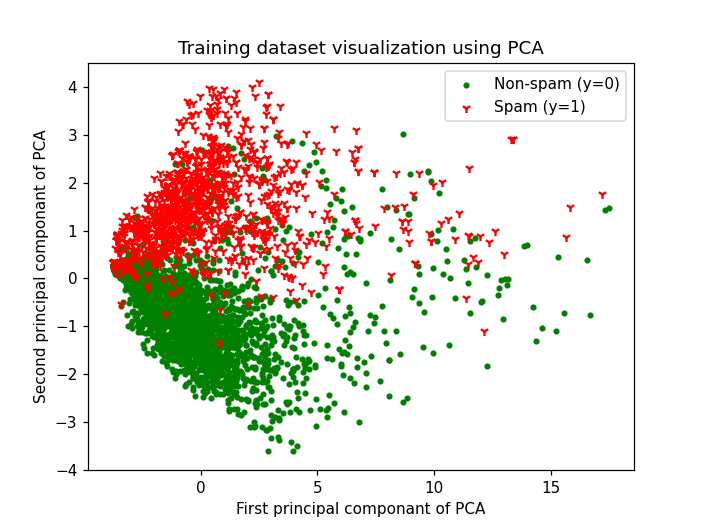

In [4]:
%matplotlib notebook
import matplotlib.pylab as plt
from scipy.io import loadmat

"""TODO:
Read and understand all the code below, then run it.
"""

# Loading the training dataset into X (inputs) and y (outputs)
mat = loadmat("datasets/spamTrain.mat")
X = mat["X"]
y = mat["y"].reshape(len(X))
print("X.shape:", X.shape, "y.shape:", y.shape)

# Loading the testing dataset into Xtest (inputs) and ytest (outputs)
mat = loadmat("datasets/spamTest.mat")
Xtest = mat["Xtest"]
ytest = mat["ytest"].reshape(len(Xtest))
print("Xtest.shape:", Xtest.shape, "ytest.shape:", ytest.shape)

# Visualizing the high-dimensional dataset using PCA
from sklearn.decomposition import PCA
X_pca = PCA(n_components = 2).fit_transform(X)

fig, ax = plt.subplots()
X0_pca, X1_pca = X_pca[y==0], X_pca[y==1]
ax.scatter(X0_pca[:, 0], X0_pca[:, 1], marker=".", color="green", label="Non-spam (y=0)")
ax.scatter(X1_pca[:, 0], X1_pca[:, 1], marker="1", color="red", label="Spam (y=1)")
ax.set_xlabel("First principal componant of PCA")
ax.set_ylabel("Second principal componant of PCA")
ax.set_title("Training dataset visualization using PCA")
ax.legend()
fig.show()

After loading the dataset, the following Python code will proceed to train a linear SVM with $C=0.03$ to classify between spam ($y^{(i)} = 1$) and non-spam ($y^{(i)} = 0$) emails.

Complete the code to compute the accuracy on the training set and the accuracy on the test set. Once the training completes (it may take some time, few seconds), you should see that the classifier gets a training accuracy of about 99.4% and a test accuracy of about 99.0%.

In [8]:
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = SVC(C=0.03, kernel="linear").fit(X, y)

""" TODO:
Compute here the training accuracy and the test accuracy of clf.
"""
# acc_train = ...
acc_train = clf.score(X_train, y_train)
# acc_test = ...
acc_test = clf.score(X_test, y_test)
# print("Training Accuracy = {}, Test Accuracy = {}".format(acc_train, acc_test))
print("Training Accuracy = {}, Test Accuracy = {}".format(acc_train, acc_test))

Training Accuracy = 0.9946875, Test Accuracy = 0.9925


## 4. Top Predictors for Spam
In this section, to better understand how the spam classifier works, we can inspect the parameters to see which words (i.e. features) the classifier thinks are the most predictive of spam (i.e. most important features for predicting spams).

Since the model we are training is a linear SVM, we can inspect the parameter values $\theta_j$ learned by the model to understand better how it is determining whether an email is spam or not. In order words, we need to find the parameters with the largest positive values in the classifier and displays the corresponding words.

The following code gives you the vector of parameters $\theta$ from the SVM model `clf` trained previously. Your task is to complete the code to find the 10 words associated with the highest weights (parameter values) in the classifier.

In our case, we found out that if an email contains words such as 'click', 'remov', 'basenumb', 'our', 'guarante', 'visit', 'pleas', 'you', 'dollar', and 'here' (the top 10 predictors), it is likely to be classified as spam. Informally, the classifier "thinks" that these words are the most likely indicators of spam.

In [9]:
# The parameters vector theta = [theta_0, theta_1, ..., theta_1899]
theta = np.concatenate([clf.intercept_, clf.coef_[0]])

# Let's ignore theta_0 as it is not multiplied by any feature value
theta = theta[1:] # now theta = [theta_1, ..., theta_1899]

""" TODO:
Write code to find out which 10 words (i.e. features) the classifier thinks are the most 
predictive of spam (from the vocabulary). These words correspond to the features that are 
multiplied by the highest parameter values theta_j. So you need to find the indices of the 
highest parameter values, and print the vocabulary words corresponding to these indices. You 
can use np.argsort(arr) which returns the indices that would sort an array.
"""
# ...
# ...
top_indices = np.argsort(theta)[::-1][:10] 
top_words = vocabulary[top_indices] 
print("Top 10 words predictive of spam: {}".format(top_words))

Top 10 words predictive of spam: ['click' 'remov' 'basenumb' 'our' 'guarante' 'visit' 'pleas' 'you'
 'dollar' 'here']


## 5. Try your own emails
Now that you have trained a spam classifier, you can start trying it out on your own emails. To do so, you can replace the email text below (variable `email_text`) with your own email content (it should be a plain English text), and see the result of the prediction; it's fun.

In [10]:
email_text = """
Do You Want To Make $1000 Or More Per Week?

If you are a motivated and qualified individual - I 
will personally demonstrate to you a system that will 
make you $1,000 per week or more! This is NOT mlm.

Call our 24 hour pre-recorded number to get the 
details.

000-456-789

I need people who want to make serious money.  Make 
the call and get the facts. Invest 2 minutes in yourself now!

000-456-789

Looking forward to your call and I will introduce you 
to people like yourself who
are currently making $10,000 plus per week!"""


x = email_to_vector(vocabulary, email_text) # Converting the raw email text to a feature-vector x
pred = clf.predict([x])[0]                  # Predicting the output for this single data-point x
print("Prediction: ", "SPAM" if pred==1 else "NON-SPAM") # Printing the predicted class-label.


Prediction:  SPAM


## B.6. Optional (ungraded) task: Build your own dataset
**NOTE:** The following task (this section) is optional and it's up to you if you want to do it or not.

In this Lab, we provided to you a preprocessed training set and test set. These datasets were created using the same function `email_to_vector(..)` that you now have completed. For this optional (ungraded) task, you can build your own dataset using the original emails from the SpamAssassin Public Corpus. Your task is to download the original files from the public corpus and extract them. After extracting them, you should run the `email_to_vector(..)` function on each email to extract a feature-vector from each email. This will allow you to build a dataset $X, y$ of examples. You should then randomly divide up the dataset into a training set, a cross validation set and a test set.

While you are building your own dataset, we also encourage you to try building your own vocabulary list (by selecting the high frequency words that occur in the dataset) and adding any additional features that you think might be useful. Finally, we can try to train and evaluate an SVM model on the datasets that you construct.

Note that the original emails will have email headers that you might wish to leave out.